# Weather Data Preprocessing Workflow

This notebook processes weather datasets for Delhi and Mumbai, creating a clean, gap-free, and feature-engineered dataset for energy consumption and demand response modeling. The goal is to produce standardized and consistent weather inputs ready for analysis or machine learning.

---

## Workflow Steps

1. **Load Data** – import internal weather (2023–2024), customer location, and external ERA5 datasets; merge by city; preprocess features (unit conversion, wind speed/direction).  
2. **Clean Outliers** – detect and replace invalid or missing latitude/longitude values.  
3. **Extract Coordinates** – parse latitude/longitude from location fields.  
4. **Impute Missing Records** – fill midnight gaps using averages of adjacent hours.  
5. **Spatial Interpolation** – map ERA5 features to customer coordinates at matching timestamps.  
6. **EDA Checks** – visualize and summarize missing values, distributions, and correlations.  
7. **Feature Reduction** – drop redundant or highly correlated features.  
8. **Resample to Half-Hourly** – interpolate hourly data to 30-minute intervals.  
9. **Export Final Dataset** – combine Delhi and Mumbai and save as CSV.

---

### Import the module

In [2]:
# Standard library imports
import math
import os
import re
from typing import Hashable, Iterable, Optional

# Third-party imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pandas.api.types import CategoricalDtype
from scipy.stats import gaussian_kde, probplot, shapiro
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from functools import partial
from scipy.interpolate import griddata

# pip install xarray cfgrib (for reading .grib files)


In [3]:
# Custom function to read CSV with missing value checks (similar to example_dataset_preprocess.ipynb)
def read_csv_with_checks(file_path, **read_csv_kwargs):
    """
    Reads a CSV file into a DataFrame, reports columns with missing values,
    and returns the DataFrame.

    Parameters
    ----------
    file_path : str
        Path to the CSV file.
    **read_csv_kwargs :
        Extra keyword arguments forwarded to `pd.read_csv`
        (e.g. dtype=…, low_memory=False, chunksize=…).

    Returns
    -------
    pd.DataFrame
        The loaded DataFrame.

    Raises
    ------
    FileNotFoundError
        If the file does not exist.
    Exception
        For any other unexpected errors.
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        df = pd.read_csv(file_path, **read_csv_kwargs)

        # Count missing values per column and keep only the non-zero ones
        missing_summary = df.isnull().sum()
        missing_summary = (
            missing_summary[missing_summary > 0]
            .sort_values(ascending=False)
        )

        if not missing_summary.empty:
            with pd.option_context("display.max_rows", None):
                print("Missing-value report:")
                print(missing_summary)
        else:
            print("No missing values detected.")

        print(f"Data loaded successfully. Number of records: {len(df):,}")
        return df

    except FileNotFoundError:
        raise  # re-raise so the caller can handle it
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise


### Load the internal weather data

In [4]:
# load the weather data
print("===== weather_delhi_2023: =====")
weather_delhi_2023 = read_csv_with_checks('../power-data/weather-delhi-2023.csv')
print("\n===== weather_delhi_2024: =====")
weather_delhi_2024 = read_csv_with_checks('../power-data/weather-delhi-2024.csv')

print("\n===== weather_mumbai_2023: =====")
weather_mumbai_2023 = read_csv_with_checks('../power-data/weather-mumbai-2023.csv')
print("\n===== weather_mumbai_2024: =====")
weather_mumbai_2024 = read_csv_with_checks('../power-data/weather-mumbai-2024.csv')

===== weather_delhi_2023: =====
Missing-value report:
surface_net_solar_radiation          62100
surface_solar_radiation_downwards    62100
dtype: int64
Data loaded successfully. Number of records: 251,850

===== weather_delhi_2024: =====
No missing values detected.
Data loaded successfully. Number of records: 252,540

===== weather_mumbai_2023: =====
Missing-value report:
surface_net_solar_radiation          31050
surface_solar_radiation_downwards    31050
dtype: int64
Data loaded successfully. Number of records: 125,925

===== weather_mumbai_2024: =====
No missing values detected.
Data loaded successfully. Number of records: 126,270


Merge the two year data

In [5]:
# Merge the weather data for two years
weather_delhi = pd.concat([weather_delhi_2023, weather_delhi_2024], ignore_index=True)
weather_mumbai = pd.concat([weather_mumbai_2023, weather_mumbai_2024], ignore_index=True)

# delete the individual year dataframes to free up memory
del weather_delhi_2023
del weather_delhi_2024
del weather_mumbai_2023
del weather_mumbai_2024

import gc
gc.collect()

5

Load the customer location dataset data

In [6]:
# Load the customer location data
delhi_customers = read_csv_with_checks('../power-data/delhi-customers.csv')
mumbai_customers = read_csv_with_checks('../power-data/mumbai-customers.csv')

# Add 'city' column, indicating the city for each customer before merging
delhi_customers['city'] = 'delhi'
mumbai_customers['city'] = 'mumbai'

# Merge with city info
all_customers = pd.concat([delhi_customers, mumbai_customers], ignore_index=True)

# Rename 'Lat' and 'Lon' columns to 'latitude' and 'longitude' in all_customers
all_customers = all_customers.rename(columns={'Lat': 'latitude', 'Lon': 'longitude'})

No missing values detected.
Data loaded successfully. Number of records: 398
No missing values detected.
Data loaded successfully. Number of records: 116


### Load the external dataset and preprocess the features

In [8]:
# Load the external weather data, reference: https://cds.climate.copernicus.eu
weather_delhi_2023_external = read_csv_with_checks('../power-data/weather_delhi_2023_external.csv')
weather_delhi_2024_external = read_csv_with_checks('../power-data/weather_delhi_2024_external.csv')
weather_mumbai_2023_external = read_csv_with_checks('../power-data/weather_mumbai_2023_external.csv')
weather_mumbai_2024_external = read_csv_with_checks('../power-data/weather_mumbai_2024_external.csv')

Missing-value report:
ssrd            361890
ssr             361890
tp              361890
step_y          361350
number_y        361350
surface_y       361350
valid_time_y    361350
number_x           540
step_x             540
surface_x          540
valid_time_x       540
sp                 540
tcc                540
u10                540
v10                540
t2m                540
dtype: int64
Data loaded successfully. Number of records: 756,090
Missing-value report:
ssrd            362880
ssr             362880
tp              362880
step_y          362340
number_y        362340
surface_y       362340
valid_time_y    362340
number_x           540
step_x             540
surface_x          540
valid_time_x       540
sp                 540
tcc                540
u10                540
v10                540
t2m                540
dtype: int64
Data loaded successfully. Number of records: 758,160
Missing-value report:
ssrd            361890
ssr             361890
tp              3618

In [9]:
# Merge the external weather data for two years
weather_delhi_external = pd.concat([weather_delhi_2023_external, weather_delhi_2024_external], ignore_index=True)
weather_mumbai_external = pd.concat([weather_mumbai_2023_external, weather_mumbai_2024_external], ignore_index=True)

# delete the individual year external dataframes to free up memory
del weather_delhi_2023_external
del weather_delhi_2024_external
del weather_mumbai_2023_external
del weather_mumbai_2024_external

In [10]:
# Print all column names of the DataFrame
print(weather_delhi_external.columns.tolist())

['time', 'latitude', 'longitude', 'number_x', 'step_x', 'surface_x', 'valid_time_x', 'sp', 'tcc', 'u10', 'v10', 't2m', 'step_y', 'number_y', 'surface_y', 'valid_time_y', 'ssrd', 'ssr', 'tp']


### Rename columns and select features for external weather datasets

In [11]:
# Apply column selection and renaming for all external weather datasets
feature_columns = ['time', 'latitude', 'longitude','sp', 'tcc', 'u10', 'v10', 't2m', 'ssrd', 'ssr', 'tp']
rename_dict = {
    'time': 'timestamp',
    'sp': 'Surface_Pressure',
    'tcc': 'Total_Cloud_Cover',
    'u10': 'Wind_U_Component_10m',
    'v10': 'Wind_V_Component_10m',
    't2m': 'Air_Temperature_2m',
    'ssrd': 'Surface_Solar_Radiation_Downwards',
    'ssr': 'Surface_Net_Solar_Radiation',
    'tp': 'Total_Precipitation'
}

external_dfs = [
    weather_delhi_external,
    weather_mumbai_external,
]

for i in range(len(external_dfs)):
    try:
        external_dfs[i] = external_dfs[i][feature_columns].copy()
        external_dfs[i] = external_dfs[i].rename(columns=rename_dict)
    except KeyError as e:
        print(f"Dataset {i} already transferred or missing columns: {e}")
        raise

# Unpack back to original variables
weather_delhi_external, weather_mumbai_external = external_dfs

- Select the data within from 2023 to 2024

In [12]:
# Only keep the 2023 and 2024 data in weather_delhi_external and weather_mumbai_external
weather_delhi_external['timestamp'] = pd.to_datetime(weather_delhi_external['timestamp'])
weather_mumbai_external['timestamp'] = pd.to_datetime(weather_mumbai_external['timestamp'])

weather_delhi_external = weather_delhi_external[
    weather_delhi_external['timestamp'].dt.year.isin([2023, 2024])
].copy()

weather_mumbai_external = weather_mumbai_external[
    weather_mumbai_external['timestamp'].dt.year.isin([2023, 2024])
].copy()

- In the external weather data, we can see that the 'Air_Temperature_2m' is in Kelvin.

In [13]:
# Convert Air_Temperature_2m from Kelvin to Celsius in external weather data
weather_delhi_external['Air_Temperature_2m'] = weather_delhi_external['Air_Temperature_2m'] - 273.15
weather_mumbai_external['Air_Temperature_2m'] = weather_mumbai_external['Air_Temperature_2m'] - 273.15

- Also we need to calculate the wind speed and direction to make sure the features are same as in the internal weather data


In [14]:
# Calculate wind speed (magnitude)
weather_delhi_external['wind_speed'] = np.sqrt(
    weather_delhi_external['Wind_U_Component_10m']**2 +
    weather_delhi_external['Wind_V_Component_10m']**2
)

weather_mumbai_external['wind_speed'] = np.sqrt(
    weather_mumbai_external['Wind_U_Component_10m']**2 +
    weather_mumbai_external['Wind_V_Component_10m']**2
)

# Calculate wind direction (degrees, meteorological convention: 0° = North, 90° = East)
weather_delhi_external['wind_direction'] = (
    (np.arctan2(
        weather_delhi_external['Wind_U_Component_10m'],
        weather_delhi_external['Wind_V_Component_10m']
    ) * 180 / np.pi) % 360
)

weather_mumbai_external['wind_direction'] = (
    (np.arctan2(
        weather_mumbai_external['Wind_U_Component_10m'],
        weather_mumbai_external['Wind_V_Component_10m']
    ) * 180 / np.pi) % 360
)

### Handle the Customers Data outlier

- print the range of Lat and Lon for delhi_customers and mumbai_customers to ensure they are within the expected bounds

In [15]:
# check the range of Lat and Lon for delhi_customers and mumbai_customers

# print the range of Lat and Lon for delhi_customers
print("Delhi Customers Latitude Range:", delhi_customers['Lat'].min(), "to", delhi_customers['Lat'].max())
print("Delhi Customers Longitude Range:", delhi_customers['Lon'].min(), "to", delhi_customers['Lon'].max())

# print the range of Lat and Lon for mumbai_customers
print("Mumbai Customers Latitude Range:", mumbai_customers['Lat'].min(), "to", mumbai_customers['Lat'].max())
print("Mumbai Customers Longitude Range:", mumbai_customers['Lon'].min(), "to", mumbai_customers['Lon'].max())


Delhi Customers Latitude Range: 28.62371412 to 57.36780793
Delhi Customers Longitude Range: 76.97422865 to 154.3207384
Mumbai Customers Latitude Range: 0.0 to 19.28604988
Mumbai Customers Longitude Range: 0.0 to 72.91167413


The range of Lat and Lon for delhi_customers and mumbai_customers show that there some outliers
- CID: 60006377877,	Lat: 57.36780793, Lon: 154.3207384	City: delhi (Not in India)
- CID: 900001108756, Lat: 0.0, Lon: 0.0 City: mumbai (Missing value)


In [16]:
# Replace outlier customer locations with NaN
delhi_customers.loc[delhi_customers['CA_ID'] == 60006377877, ['Lat', 'Lon']] = np.nan
mumbai_customers.loc[mumbai_customers['CA_ID'] == 900001108756, ['Lat', 'Lon']] = np.nan

In [ ]:
# Now re-check the range of Lat and Lon for delhi_customers and mumbai_customers

# print the range of Lat and Lon for delhi_customers
print("Delhi Customers Latitude Range:", delhi_customers['Lat'].min(), "to", delhi_customers['Lat'].max())
print("Delhi Customers Longitude Range:", delhi_customers['Lon'].min(), "to", delhi_customers['Lon'].max())

# print the range of Lat and Lon for mumbai_customers
print("Mumbai Customers Latitude Range:", mumbai_customers['Lat'].min(), "to", mumbai_customers['Lat'].max())
print("Mumbai Customers Longitude Range:", mumbai_customers['Lon'].min(), "to", mumbai_customers['Lon'].max())

Delhi Customers Latitude Range: 28.62371412 to 28.85692412
Delhi Customers Longitude Range: 76.97422865 to 77.22859803
Mumbai Customers Latitude Range: 18.98446843 to 19.28604988
Mumbai Customers Longitude Range: 72.82098984 to 72.91167413


### Extract Lat and Lon from 'location' column for weather data

In [ ]:
# Extract Lat and Lon from 'location' column for weather data
def extract_lat_lon(point_str):
    # Example input: 'POINT (77.03999999999999 28.8)'
    match = re.match(r'POINT \(([-\d\.]+) ([-\d\.]+)\)', point_str)
    if match:
        lon, lat = match.groups()
        return float(lat), float(lon)
    return None, None

In [ ]:
# Apply the function to extract latitude and longitude for delhi
weather_delhi[['latitude', 'longitude']] = weather_delhi['location'].apply(
    lambda x: pd.Series(extract_lat_lon(x))
)
# Drop the original 'location' column
weather_delhi = weather_delhi.drop(columns=['location'])

# Apply the function to extract latitude and longitude for Mumbai
weather_mumbai[['latitude', 'longitude']] = weather_mumbai['location'].apply(
    lambda x: pd.Series(extract_lat_lon(x))
)
# Drop the original 'location' column
weather_mumbai = weather_mumbai.drop(columns=['location'])

### Impute the weather data

In [ ]:
# Impute missing 00:00 data for both Delhi and Mumbai

def impute_missing_midnight(df, features):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df[features] = df[features].fillna(0)
    grouped = df.groupby(['latitude', 'longitude'])
    imputed_rows = []

    for (lat, lon), group in grouped:
        group = group.sort_values('timestamp')
        dates = group['timestamp'].dt.date.unique()
        for date in dates:
            dt_00 = pd.Timestamp(f"{date} 00:00")
            dt_23 = dt_00 - pd.Timedelta(hours=1)
            dt_01 = dt_00 + pd.Timedelta(hours=1)
            row_00 = group[group['timestamp'] == dt_00]
            row_23 = group[group['timestamp'] == dt_23]
            row_01 = group[group['timestamp'] == dt_01]
            if row_00.empty and not row_23.empty and not row_01.empty:
                avg_vals = {}
                for f in features:
                    avg_vals[f] = (row_23.iloc[0][f] + row_01.iloc[0][f]) / 2
                new_row = row_01.iloc[0].copy()
                new_row['timestamp'] = dt_00
                for f in features:
                    new_row[f] = avg_vals[f]
                imputed_rows.append(new_row)

    if imputed_rows:
        df = pd.concat([df, pd.DataFrame(imputed_rows)], ignore_index=True)
        df = df.sort_values(['latitude', 'longitude', 'timestamp']).reset_index(drop=True)
    return df

features = [
    'wind_speed', 'wind_direction', 'temperature', 'precipitation',
    'surface_net_solar_radiation', 'surface_solar_radiation_downwards'
]

weather_delhi = impute_missing_midnight(weather_delhi, features)
weather_mumbai = impute_missing_midnight(weather_mumbai, features)

### Merge the weather data with external data

In [ ]:
# Interpolate weather features from an external dataset onto the lat/lon of target_df (weather dataset) at matching times
def interpolate_features(source_df, target_df, features, method='linear'):
    """
    Interpolates weather features from source_df onto the lat/lon of target_df at matching times.

    Parameters:
        source_df (DataFrame): The external dataset with weather features (lat/lon/time/grid).
        target_df (DataFrame): The dataset to interpolate values into.
        features (list): List of feature names to interpolate.
        method (str): Interpolation method ('linear', 'nearest', 'cubic').

    Returns:
        target_df with interpolated columns added.
    """
    target_df = target_df.copy()

    for feature in features:
        interpolated_values = []

        # Loop through each unique time
        for t in target_df['timestamp'].unique():
            src = source_df[source_df['timestamp'] == t]
            tgt = target_df[target_df['timestamp'] == t]

            if src.empty or tgt.empty:
                interpolated_values.extend([np.nan] * len(tgt))
                continue

            # Interpolate feature from source lat/lon → target lat/lon
            interp = griddata(
                points=src[['latitude', 'longitude']].values,
                values=src[feature].values,
                xi=tgt[['latitude', 'longitude']].values,
                method=method
            )
            interpolated_values.extend(interp)

        # Add new column
        target_df[feature] = interpolated_values

    return target_df


In [ ]:
# Interpolate features for both Delhi and Mumbai datasets

features_to_interpolate = ['Surface_Pressure', 'Total_Cloud_Cover']

weather_delhi_full = interpolate_features(
    source_df=weather_delhi_external,
    target_df=weather_delhi,
    features=features_to_interpolate,
    method='linear'  # or 'nearest'
)

weather_mumbai_full = interpolate_features(
    source_df=weather_mumbai_external,
    target_df=weather_mumbai,
    features=features_to_interpolate,
    method='linear'  # or 'nearest'
)

### EDA process for the weather data

Delhi Weather Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526290 entries, 0 to 526289
Data columns (total 12 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   timestamp                          526290 non-null  datetime64[ns]
 1   wind_speed                         526290 non-null  float64       
 2   wind_direction                     526290 non-null  float64       
 3   temperature                        526290 non-null  float64       
 4   city                               526290 non-null  object        
 5   precipitation                      526290 non-null  float64       
 6   surface_net_solar_radiation        526290 non-null  float64       
 7   surface_solar_radiation_downwards  526290 non-null  float64       
 8   latitude                           526290 non-null  float64       
 9   longitude                          526290 non-null  float64       
 10  

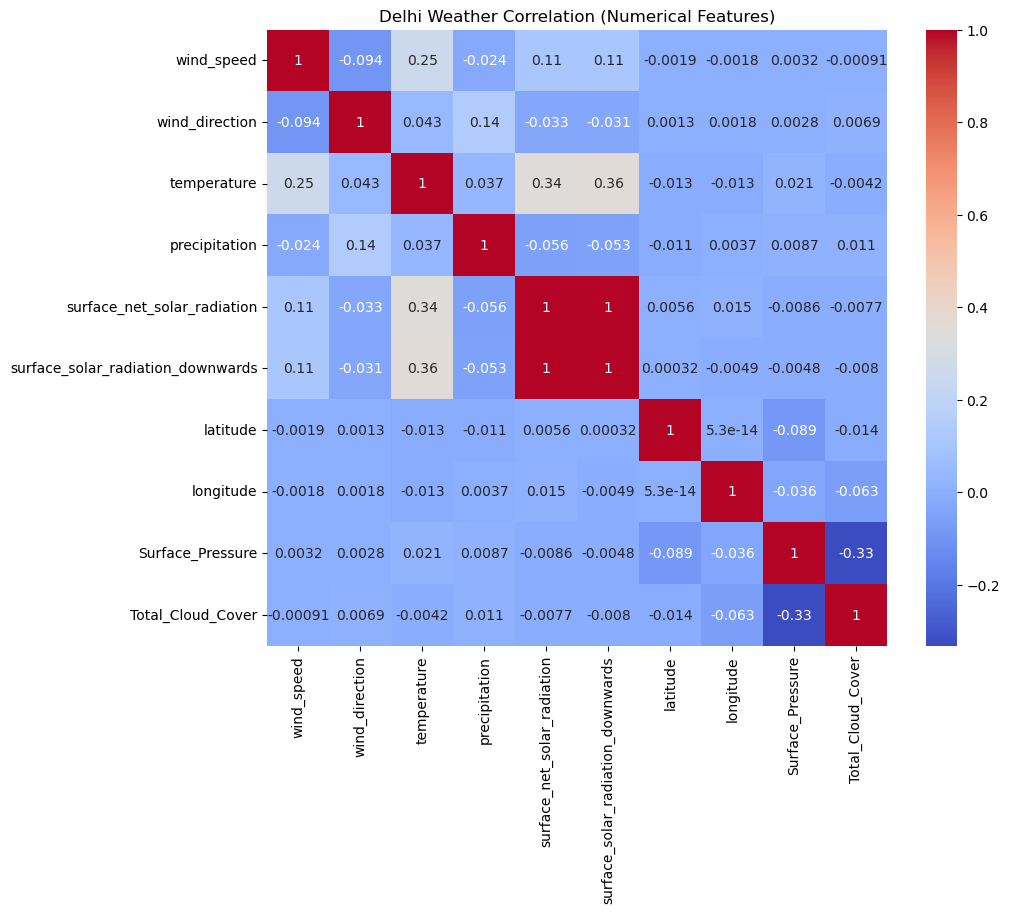

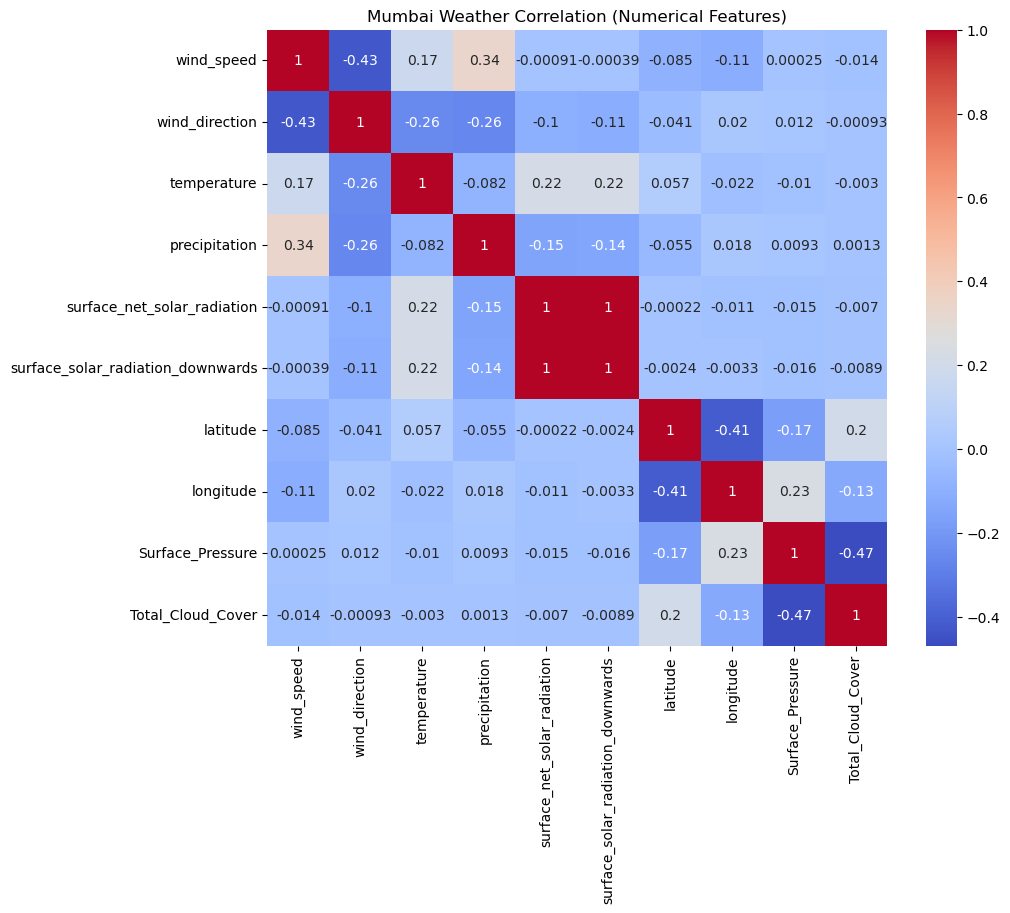

In [ ]:
# Basic info
print("Delhi Weather Info:")
weather_delhi_full.info()
print("\nMumbai Weather Info:")
weather_mumbai_full.info()

# Summary statistics
print("\nDelhi Weather Summary:")
print(weather_delhi_full.describe(include='all').T)
print("\nMumbai Weather Summary:")
print(weather_mumbai_full.describe(include='all').T)

# Check missing values
print("\nDelhi Missing Values:")
print(weather_delhi_full.isnull().sum())
print("\nMumbai Missing Values:")
print(weather_mumbai_full.isnull().sum())


# Correlation heatmap for numerical features only
plt.figure(figsize=(10,8))
num_features_delhi = weather_delhi_full.select_dtypes(include=[np.number])
sns.heatmap(num_features_delhi.corr(), annot=True, cmap='coolwarm')
plt.title('Delhi Weather Correlation (Numerical Features)')
plt.show()

plt.figure(figsize=(10,8))
num_features_mumbai = weather_mumbai_full.select_dtypes(include=[np.number])
sns.heatmap(num_features_mumbai.corr(), annot=True, cmap='coolwarm')
plt.title('Mumbai Weather Correlation (Numerical Features)')
plt.show()

In [ ]:
# Drop the highly correlated features
weather_delhi_full = weather_delhi_full.drop(columns=['surface_solar_radiation_downwards'])
weather_mumbai_full = weather_mumbai_full.drop(columns=['surface_solar_radiation_downwards'])

In [ ]:
# # Visualize customer locations and weather station locations on a map for Delhi (only for Jupyter Notebook)

# import folium
# # Center the map at the mean location
# center_lat = weather_delhi['latitude'].mean()
# center_lon = weather_delhi['longitude'].mean()
# m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# # Add points
# for _, row in weather_delhi.iterrows():
#     folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=2, color='blue').add_to(m)

# m  # Display the map in Jupyter

### Save the weather data and make the format same with powbal_data

In [ ]:
# Impute hourly data to half-hourly data for weather_delhi_full and weather_mumbai_full

def resample_to_half_hour(df, time_col='timestamp', group_cols=['latitude', 'longitude']):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    # List of columns to interpolate (exclude group and time)
    value_cols = [col for col in df.columns if col not in group_cols + [time_col, 'city']]  # adjust if needed

    # Store all resampled chunks
    resampled_dfs = []

    for keys, group in df.groupby(group_cols):
        group = group.set_index(time_col).sort_index()
        group_resampled = group.resample('30T').interpolate(method='linear')
        # Restore group keys
        for col, val in zip(group_cols, keys):
            group_resampled[col] = val
        resampled_dfs.append(group_resampled.reset_index())

    return pd.concat(resampled_dfs, ignore_index=True)


In [ ]:
weather_delhi_halfhour = resample_to_half_hour(weather_delhi_full, time_col='timestamp', group_cols=['latitude', 'longitude'])
weather_mumbai_halfhour = resample_to_half_hour(weather_mumbai_full, time_col='timestamp', group_cols=['latitude', 'longitude'])

C:\Users\11581\AppData\Local\Temp\ipykernel_31828\4063903323.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('30T').interpolate(method='linear')
C:\Users\11581\AppData\Local\Temp\ipykernel_31828\4063903323.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group_resampled = group.resample('30T').interpolate(method='linear')
C:\Users\11581\AppData\Local\Temp\ipykernel_31828\4063903323.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('30T').interpolate(method='linear')
C:\Users\11581\AppData\Local\Temp\ipykernel_31828\4063903323.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) befor

In [ ]:
# Merge the two city weather datasets
weather_delhi_halfhour['city'] = 'Delhi'
weather_mumbai_halfhour['city'] = 'Mumbai'
weather_full = pd.concat([weather_delhi_halfhour, weather_mumbai_halfhour], ignore_index=True)

# Save the interpolated DataFrames to CSV files
weather_full.to_csv('../power-data/weather_full.csv', index=False)